In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import os

# EXPLICIT CONTENT PRE-PROCESSING

# Step I
## Convert to CSV
This step includes importing all the scrapped links into the program from the `../data-scrapper/data` folder.
After importing, at first, the data will have an extra row added atop the data to label all the columns to enable dealing with pandas library to preprocess the data.
This includes the following columns:
1. `img_link` - this is the url scrapped by the data-scrapper
2. `category` - this is the category that is attached with the scrapped url
3. `is_explicit` - this is the label on whether the image is explicit or not, this is a binary option `(yes, no)`

After this row with the two column labels is added, the label column is added to all row containing the link and the newly added label to dictate whether the image is ecplicit or not, this is very important for training and evaluation purposes.

`NOTE`:
As from noted whitespaces in between the data columns (esp. in first row for failed scrapping attempts), the creation of csv files will take into consideration that all the white spaces have to be scrapped off.

In [2]:
all_categories = os.scandir("../data-scrapper/data")

for category in all_categories:
    with open(category.path) as open_category:
        labels = ["img_link,category,is_explicit\n"]
        for line in open_category.readlines():
            category_name = category.name.replace(".txt", "")
            # check if it is an empty line, only executes if it is not an empty row
            # also makes sure that we do not add any link with a comma in it as it may lead to parsing csv issues
            if line != "\n" and not "," in line:
                new_line = line.replace("\n", "") + f",{category_name},yes\n"
                labels.extend([new_line])
        with open(f"data/explicit/{category.name.replace('.txt', '.csv')}", "w") as new_csv:
            new_csv.writelines(labels)

# Step II
## Remove redundancies
This section tries to make sure that the data does not contain any redundancies in the training set as they moght lead to overfitting in the machine learning model.
After redundancies are spotted,they are removed and a new csv is created without those redundancies.

In order to try and increase the dataset size, in categories that were found to have only one unique image, the category was completley done away (deleted from the `data-scrapper` directory) with and the category was then handed back to the scrapper to try and ensure that images from that category would be populated afresh.

94it [00:01, 58.63it/s]


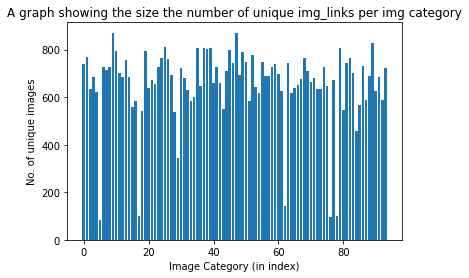

100%|███████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]

purging 3 categories...
purge Babysitter.txt
purge Russian.txt
purge SFW0.txt
successfully purged imbalanced datasets.


In [3]:
img_category_no = []
img_category_count = []
unique_images = []
# keeps track of categories with minimal data size (i.e below 100) and these categories will be redownloaded
imbalanced_categories = []

for i, csv in tqdm(enumerate(os.scandir("data/explicit"))):
    # to prevent opening directories which may lead to program failure, all files must satisfy having the ".csv" extension
    # before commencing the process fo opening
    if ".csv" in csv.name:
        open_csv = pd.read_csv(csv.path)
        category_name = csv.name.replace(".csv", "")
        dataset_size = len(pd.unique(open_csv["img_link"]))
        if (dataset_size > 100):
            unique_images.append({"category": category_name,"images": pd.unique(open_csv["img_link"])})
        else:
            imbalanced_categories.append(csv.name.replace(".csv", ".txt"))

        img_category_count.append(dataset_size) # keep track of dataset size per category
        img_category_no.append(i)

# print the data bar graph to help decide what size should be snipped from each category
plt.title("A graph showing the size the number of unique img_links per img category")
plt.xlabel("Image Category (in index)")
plt.ylabel("No. of unique images")
plt.bar(img_category_no, img_category_count)
plt.show()
    
# purge all the imbalanced categories:
print(f"purging {len(imbalanced_categories)} categories...")

for cat in tqdm(imbalanced_categories):
    try:
#         os.remove(f"../data-scrapper/data/{cat}")
        print(f"purge {cat}")
    except:
        pass

print("successfully purged imbalanced datasets.")

# Step III
## combine all the data into one csv
After removing redundancies in single categories, the data is combined to remove redundancies in the whole dataset. This includes:
1. Images overlapped categories thus need to remove is there even if the image is classified over several categories.
2. Re-add the labelling column (img_urls,category,is_explicit)

`NOTE`
A redundant image is only added with its first seen category.

In [4]:
# Moving on with categories that are well balanced and all the unique images
print(len(unique_images))
# We keep track of the added images in the global csv by adding any image that is appended to the global csv to this list.
# Before any new image is added, we first make sure that the image url is not found in this list that keeps track of image
# urls added to the global csv.
added_images = []
combined_csv = ["img_link,category,is_explicit\n"]  # add the labelling row for the csv

print("Searching for redundancies...")
for category_images in tqdm(unique_images):
    for img in category_images["images"]:  # iterate through only the images in the dict.
        try:
            added_images.index(img)
        except ValueError as ve:
            # error means that the image is not redundant
            new_row = f"{img},{category_images['category']},yes\n"
            combined_csv.extend([new_row])  # added as an array to allow the use of file.writelines to write to file
            added_images.append(img)

print(f"redundancies removed. {len(added_images)} unique rows of images left.")
print("writing to csv...")
with open("data/processed-data/explicit/combined.csv", "w") as combined_data:
    combined_data.writelines(combined_csv)
print("saved to: data/processed-data/explicit/combined.csv")

  5%|██▌                                           | 5/91 [00:00<00:01, 45.45it/s]

91
Searching for redundancies...


100%|█████████████████████████████████████████████| 91/91 [00:19<00:00,  4.63it/s]

redundancies removed. 39345 unique rows of images left.
writing to csv...
saved to: data/processed-data/explicit/combined.csv


# Step IV
## Convert The Categorical inputs into numerical data
This involves changing up the column `is_explicit` into a numerical column instead of the `yes|no` format it is currently in. This means that the `yes` will be converted to `1` and the `no` column will be converted into `0`.

This will allow for easier training of the model when that part arrives.

In [5]:
before_normalisation = pd.read_csv("data/processed-data/explicit/combined.csv")
print("######################## BEFORE ####################")
print(before_normalisation.head())
try:
    print("\n\n######################## AFTER ####################")
    before_normalisation["is_explicit"].replace({
        "yes": 1,
        "no": 2,
    }, inplace=True)
    print(before_normalisation.head())
    before_normalisation.to_csv("data/processed-data/explicit/combined.csv", index=False)
except:
    pass

######################## BEFORE ####################
                                            img_link category is_explicit
0  https://img-hw.xnxx-cdn.com/videos/thumbslll/b...  Amateur         yes
1  https://img-egc.xvideos-cdn.com/videos/thumbsl...  Amateur         yes
2  http://img-hw.xvideos.com/videos/thumbsll/16/3...  Amateur         yes
3  https://img-egc.xvideos-cdn.com/videos/thumbsl...  Amateur         yes
4  http://cdn1b.static.pornhub.phncdn.com/www-sta...  Amateur         yes


######################## AFTER ####################
                                            img_link category  is_explicit
0  https://img-hw.xnxx-cdn.com/videos/thumbslll/b...  Amateur            1
1  https://img-egc.xvideos-cdn.com/videos/thumbsl...  Amateur            1
2  http://img-hw.xvideos.com/videos/thumbsll/16/3...  Amateur            1
3  https://img-egc.xvideos-cdn.com/videos/thumbsl...  Amateur            1
4  http://cdn1b.static.pornhub.phncdn.com/www-sta...  Amateur            1

# NEUTRAL CONTENT PRE-PROCESSING

## Step I
### Covert scrapped links to CSV
The scrapped links are converted to CSV files containing the following categories:
1. `img_link` - the link where the image is served from
2. `category` - all set to `neutral` instead of using the ImageNet labels
2. `is_epxplicit` - all are set to `no` since none of the images is explicit

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 19395.63it/s]


Final NEUTRAL-CSV size: 19784


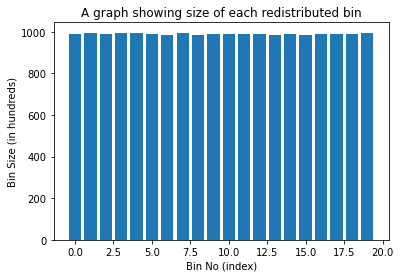

In [20]:
neutral_imgs = os.scandir("../data-scrapper/neutral-data")

labels = ["img_link,category,is_explicit\n"]

# Create a multi dimensional array of 1 x 19 this will enable creation of bins that have an image from each category
# for all the thousands of images scrapped for the neutral category.
# The aim of this is to ensure that no matter how many images are sampled, the data is evenly distributed from all categories.
img_bins = [[] for i in range(20)]  # creates a list of 19 bins


# fetch all the images and store them in the all_images variable to enable easy traversal for the binning process
for category in neutral_imgs:
    with open(category.path) as open_category:
        category_imgs = []
#          check for imbalanced categories
        for i, line in enumerate(open_category.readlines()):
            # check if it is an empty line, only executes if it is not an empty row
            # also makes sure that we do not add any link with a comma in it as it may lead to parsing csv issues
            if line != "\n" and not "," in line:
                new_line = line.replace("\n", "") + ",neutral,no\n"
                if i < 20:
                    img_bins[i].append(line)


# will hold all the redistributed images that have been balanced out
redistributed_images = ["img_link,category,is_explicit\n"]  

# # evenly redistribute the downloaded images
for img_bin in tqdm(img_bins):
    redistributed_images.extend(img_bin)

with open(f"data/neutral/neutral.csv", "w") as new_csv:
    new_csv.writelines(redistributed_images)

print(f"Final NEUTRAL-CSV size: {len(redistributed_images)}")

plt.title("A graph showing size of each redistributed bin")
plt.xlabel("Bin No (index)")
plt.ylabel("Bin Size (in hundreds)")
plt.bar([i for i in range(20)], [len(img_bin) for img_bin in img_bins])
plt.show()

## Step II
### Remove Redundancies
This step includes removing any redundancies that may be found in the data in terms of the same image being scrapped twice.
Also includes making sure that the data is balanced after the redundancies are removed.

In [88]:
neutral_csv = pd.read_csv("data/neutral/neutral.csv")
unique_imgs = pd.unique(neutral_csv["img_link"])

combined_neutral_images = ["img_link,category,is_explicit"]

for img_url in unique_imgs:
    combined_neutral_images.append(f"{img_url},neutral,0\n")

with open("data/processed-data/neutral/combined.csv", "w") as combined_neutral_file:
    combined_neutral_file.writelines(combined_neutral_images)

print(f"Size of the pre-processed CSV: {len(unique_imgs)}")

Size of the pre-processed CSV: 19722


# Creating The Datasets
In order to test the best balance between neutral an explicit images that would be used to train the dataset, I would experiment with different sizes of the data:
1. `50 - 50` - This is one in which i would give an equal number of neutral and explicit images.
2. `70 - 30` - 70% explicit, 20% neutral
3. `80 - 20` - 80% explicit images, 20% neutral
4. `90 - 10` - 90% explicit images, 10% neutral

These datasets will be observed over the training in terms of accuracy after training and during prediction in observations of things like the confusion matrix in order to determine which was most stable and would be proceeded with and optimised for best results.

`NOTE:` After the neutral and explicit images are combined, the data would be split for a 70:30 dataset:
1. 70% for the training iteration
2. 30% for the evaluation iteration

In [89]:
explicit_dataset = []
neutral_dataset = []

with open("data/processed-data/explicit/combined.csv") as ed:
    explicit_dataset = ed.readlines()
    explicit_dataset.pop(0) # remove the labelling column

with open("data/processed-data/neutral/combined.csv") as nd:
    neutral_dataset = nd.readlines()
    neutral_dataset.pop(0) # remove the labelling column


print(f"EXPLICIT: {len(explicit_dataset)} instances")
print(f"NEUTRAL: {len(neutral_dataset)} instances")

EXPLICIT: 39345 instances
NEUTRAL: 19721 instances


## Dataset Creation
### Splitting The Data
The data is spit at the basis of each 10 images, this means that if the data is `50 - 50`, then in every 10 images after splitting exists, `5 explicit` and `5 neutral`
### Saving The Refined Dataset
After creating the dataset, it is in appended the naming row `img_link,category,is_explicit` and then saved in a directory representative of how the dataset has been split and the type of data it is i.e:
1. The data is saved in a folder named `xx-yy` in which case `xx` is the percentage of the explicit data and `yy` is the percentage of the neutral data.
2. Each type of dataset is saved in a representative file. i.e:
  - `train.csv` - contains the dataset used to train
  - `test.csv` - contains the dataset used to evaluate the network.

In [90]:
# helps split the data in the propotions stated by in the method.
# NOTE: Shuffling is not done here and will be carried out in the DataLoader step in the CNN training section
def create_dataset(explicit, neutral):
    ds_combined = []
    explicit_copy = explicit_dataset.copy()
    neutral_copy = neutral_dataset.copy()
    
    # Split dataset by iterating until its impossible to iterate any more while following propotions
    while len(explicit_copy) >= explicit and len(neutral_copy) >= neutral:
        # get the explicit data
        for i in range(explicit):
            try:
                ds_combined.append(explicit_copy.pop(0))
            except IndexError as ie:
                print("Attempted to pop from an empty list")
        
        for i in range(neutral):
            try:
                ds_combined.append(neutral_copy.pop(0))
            except IndexError as ie:
                print("Attempted to pop from an empty list")

    # split data in 70-30
    train_len = int(0.7 * float(len(ds_combined)))
    
    return ds_combined[0:train_len], ds_combined[train_len:]


def save_dataset(train, test, folder_name):
    train_location = f"data/processed-data/{folder_name}/train.csv"
    test_location = f"data/processed-data/{folder_name}/test.csv"
    train_csv = ["img_link,category,is_explicit\n"]
    train_csv.extend(train)  # training csv
    test_csv = ["img_link,category,is_explicit\n"]
    test_csv.extend(test)  # testing csv
    
    def write_to(location, data):
        with open(location, "w") as target_file:
            target_file.writelines(data)
    
    write_to(train_location, train_csv)
    write_to(test_location, test_csv)
    

## 50 - 50 Dataset

In [91]:
train_set, eval_set = create_dataset(5, 5)
print(f"Training Set: {len(train_set)} against Evaluation Set: {len(eval_set)}")

save_dataset(train_set, eval_set, "50-50")

train50 = pd.read_csv("data/processed-data/50-50/train.csv")
train50.iloc[0:10]

Training Set: 27608 against Evaluation Set: 11832


,img_link,category,is_explicit
0,https://img-hw.xnxx-cdn.com/videos/thumbslll/b...,Amateur,1
1,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
2,http://img-hw.xvideos.com/videos/thumbsll/16/3...,Amateur,1
3,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
4,http://cdn1b.static.pornhub.phncdn.com/www-sta...,Amateur,1
5,https://aquaanimania.com/wp-content/uploads/20...,neutral,0
6,https://media.istockphoto.com/photos/brambling...,neutral,0
7,https://media.istockphoto.com/photos/black-swa...,neutral,0
8,https://i.ebayimg.com/images/g/QH0AAOSwDptexxw...,neutral,0
9,https://media.istockphoto.com/photos/echidna-s...,neutral,0


## 70 - 30 Dataset

In [92]:
train_set, eval_set = create_dataset(7, 3)
print(f"Training Set: {len(train_set)} against Evaluation Set: {len(eval_set)}")

save_dataset(train_set, eval_set, "70-30")

train50 = pd.read_csv("data/processed-data/70-30/train.csv")
train50.iloc[0:10]

Training Set: 39340 against Evaluation Set: 16860


,img_link,category,is_explicit
0,https://img-hw.xnxx-cdn.com/videos/thumbslll/b...,Amateur,1
1,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
2,http://img-hw.xvideos.com/videos/thumbsll/16/3...,Amateur,1
3,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
4,http://cdn1b.static.pornhub.phncdn.com/www-sta...,Amateur,1
5,https://img-hw.xnxx-cdn.com/videos/thumbslll/d...,Amateur,1
6,https://img-egc.xnxx-cdn.com/videos/thumbslll/...,Amateur,1
7,https://aquaanimania.com/wp-content/uploads/20...,neutral,0
8,https://media.istockphoto.com/photos/brambling...,neutral,0
9,https://media.istockphoto.com/photos/black-swa...,neutral,0


## 80 - 20 Dataset

In [93]:
train_set, eval_set = create_dataset(8, 2)
print(f"Training Set: {len(train_set)} against Evaluation Set: {len(eval_set)}")

save_dataset(train_set, eval_set, "80-20")

train50 = pd.read_csv("data/processed-data/80-20/train.csv")
train50.iloc[0:10]

Training Set: 34426 against Evaluation Set: 14754


,img_link,category,is_explicit
0,https://img-hw.xnxx-cdn.com/videos/thumbslll/b...,Amateur,1
1,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
2,http://img-hw.xvideos.com/videos/thumbsll/16/3...,Amateur,1
3,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
4,http://cdn1b.static.pornhub.phncdn.com/www-sta...,Amateur,1
5,https://img-hw.xnxx-cdn.com/videos/thumbslll/d...,Amateur,1
6,https://img-egc.xnxx-cdn.com/videos/thumbslll/...,Amateur,1
7,http://cdn1a.limg.pornhub.phncdn.com/m=bKW1KNV...,Amateur,1
8,https://aquaanimania.com/wp-content/uploads/20...,neutral,0
9,https://media.istockphoto.com/photos/brambling...,neutral,0


## 90 - 10 Dataset

In [94]:
train_set, eval_set = create_dataset(9, 1)
print(f"Training Set: {len(train_set)} against Evaluation Set: {len(eval_set)}")

save_dataset(train_set, eval_set, "90-10")

train50 = pd.read_csv("data/processed-data/90-10/train.csv")
train50.iloc[0:10]

Training Set: 30596 against Evaluation Set: 13114


,img_link,category,is_explicit
0,https://img-hw.xnxx-cdn.com/videos/thumbslll/b...,Amateur,1
1,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
2,http://img-hw.xvideos.com/videos/thumbsll/16/3...,Amateur,1
3,https://img-egc.xvideos-cdn.com/videos/thumbsl...,Amateur,1
4,http://cdn1b.static.pornhub.phncdn.com/www-sta...,Amateur,1
5,https://img-hw.xnxx-cdn.com/videos/thumbslll/d...,Amateur,1
6,https://img-egc.xnxx-cdn.com/videos/thumbslll/...,Amateur,1
7,http://cdn1a.limg.pornhub.phncdn.com/m=bKW1KNV...,Amateur,1
8,http://a99.nudevista.com/203/61326203.b.jpg,Amateur,1
9,https://aquaanimania.com/wp-content/uploads/20...,neutral,0
